# Lagged Rain

Let's plot the time evolution of the atmosphere up to and following intense rainfall days

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.io import shapereader
import pandas as pd
import datetime
import matplotlib.patches as patches
import paraguayfloodspy.visualize as viz
%matplotlib inline

Get some parameters and define others

In [3]:
savefigs = True
days_back = [-2, -1, 0, 1]

In [4]:
%run ../config/RioParaguay.mk
print(RPEAST, RPWEST, RPSOUTH, RPNORTH)

304.75 301.25 -26.75 -22.75


Get data: rainfall and streamfunction

In [5]:
psi = xr.open_dataset('../data/derived/psi_850.nc')
prcp = xr.open_dataset('../data/derived/precip.nc')

Get the area-averaged rainfall data in order to define rainy days as 95th percentile exceedances (can vary this parameter)

In [26]:
prcp_rpy = pd.read_csv("../data/derived/rainfall_rpy.csv", index_col='time')['raw']
rainy_days = prcp_rpy.loc[prcp_rpy > np.nanpercentile(prcp_rpy, 95)].index
rainy_days = pd.to_datetime(rainy_days)

Define some required fields for plotting

In [27]:
X,Y =  np.meshgrid(psi.lon, psi.lat)
Xp,Yp =  np.meshgrid(prcp.lon, prcp.lat)
ncols = len(days_back)

Define the color schemes here

In [28]:
cmap_streamfunc = 'PuOr'
cmap_streamfunc_a = 'PuOr'
cmap_rain = 'Greens'
cmap_raina = 'BrBG'
rain_extent = [275, 330, 5, -45]
my_extent = [-140,10,-60,10]

Specify how to draw a bounding box of the area over which rainfall is averaged to create the area-averaged rainfall!

In [29]:
def rpy_rgn():
    rec = patches.Rectangle(
        (RPWEST-360, RPSOUTH),
        RPEAST - RPWEST,
        RPNORTH - RPSOUTH,
        color = 'black', label = 'Lower PY River Basin',
        fill = None, linewidth=2
        )
    return(rec)

## Plot Anomalies

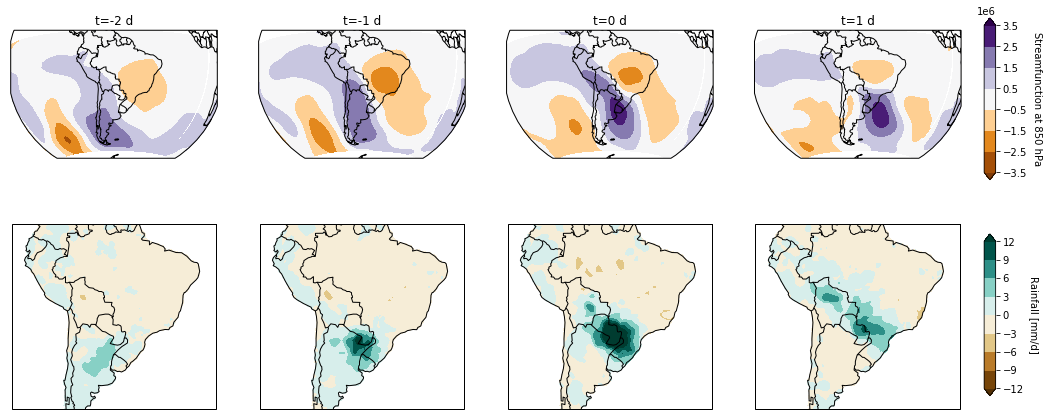

In [30]:
fig, axes = viz.SetupAxes(ncol = ncols, nax = 2*ncols, proj = ccrs.Orthographic(-60, -10), figsize = [16, 7.5])
fig.subplots_adjust(right=0.95)
cax1 = fig.add_axes([0.97, 0.55, 0.01, 0.3])
cax2 = fig.add_axes([0.97, 0.15, 0.01, 0.3])
for i,d in enumerate(days_back):
    selector = lambda ds: ds.isel(time = np.in1d(ds.time, rainy_days + datetime.timedelta(days_back[i]))).mean(dim='time')
    # Row 1: 850 hPa
    ax = axes[0, i]
    ax.set_title("t={} d".format(d))
    C1 = ax.contourf(X, Y, selector(psi['anomaly']), transform = ccrs.PlateCarree(), 
                     cmap = cmap_streamfunc_a, extend="both", levels=np.linspace(-3.5e6, 3.5e6, 8))
    # Column 2: Rainfall
    ax = axes[1, i]
    sub = selector(prcp['anomaly']).values
    sub = np.ma.masked_invalid(sub)
    C2 = ax.contourf(Xp, Yp, sub, transform = ccrs.PlateCarree(), cmap = cmap_raina, 
                     levels = np.linspace(-12, 12, 9), extend = "both")

# Add a box containing the rainfall-averaging region
for ax in axes.flat:
    ax.add_patch(rpy_rgn())
# Colorbars for Reanalysis Data
cbar1 = fig.colorbar(C1, cax = cax1)
cbar1.formatter.set_powerlimits((7, 7))
cbar1.update_ticks()
cbar1.set_label(r'Streamfunction at 850 hPa', rotation=270)
cbar1.ax.get_yaxis().labelpad = 15
# Colorbar for Rainfall
cbar2 = fig.colorbar(C2, cax=cax2)
cbar2.set_label(r'Rainfall [mm/d]', rotation=270)
cbar2.ax.get_yaxis().labelpad = 15
# Coastlines
viz.FormatAxes(axes[0,:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, ticks=None, extent=[-140,10,-60,10])
viz.FormatAxes(axes[1,:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, ticks=None,
               extent=rain_extent)
if savefigs:
    fig.savefig("../figs/LaggedRain.pdf", bbox_inches='tight')

## Full Values

As above except now don't plot anomalies

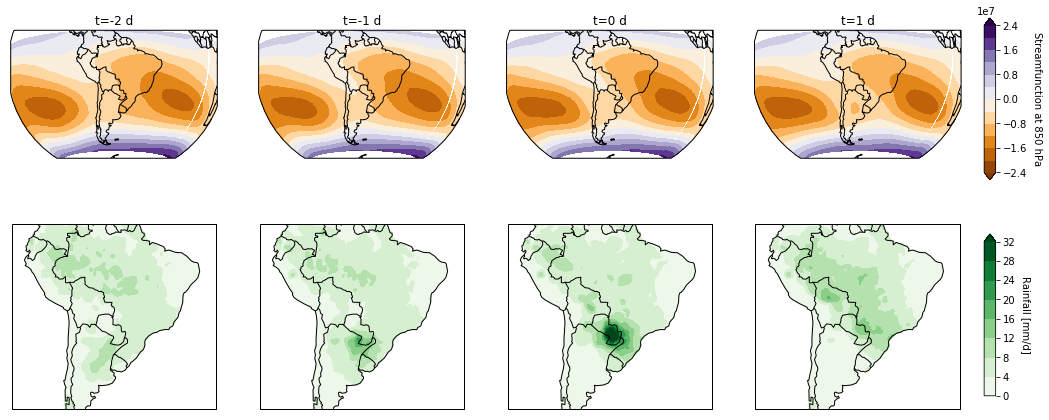

In [33]:
fig, axes = viz.SetupAxes(ncol = ncols, nax = 2*ncols, proj = ccrs.Orthographic(-60, -10), figsize = [16, 7.5])
fig.subplots_adjust(right=0.95)
cax1 = fig.add_axes([0.97, 0.55, 0.01, 0.3])
cax2 = fig.add_axes([0.97, 0.15, 0.01, 0.3])
for i,d in enumerate(days_back):
    selector = lambda ds: ds.isel(time = np.in1d(ds.time, rainy_days + datetime.timedelta(days_back[i]))).mean(dim='time')
    # Row 1: 850 hPa
    ax = axes[0, i]
    ax.set_title("t={} d".format(d))
    C1 = ax.contourf(X, Y, selector(psi['raw']), transform = ccrs.PlateCarree(), 
                     cmap = cmap_streamfunc, extend="both", levels=np.linspace(-2.4e7, 2.4e7, 13))
    # Column 2: Rainfall
    ax = axes[1, i]
    sub = selector(prcp['raw']).values
    sub = np.ma.masked_invalid(sub)
    C2 = ax.contourf(Xp, Yp, sub, transform = ccrs.PlateCarree(), cmap = cmap_rain, 
                     levels = np.linspace(0, 32, 9), extend = "max")

# Add a box containing the rainfall-averaging region
for ax in axes.flat:
    ax.add_patch(rpy_rgn())
# Colorbars for Reanalysis Data
cbar1 = fig.colorbar(C1, cax = cax1)
cbar1.formatter.set_powerlimits((7, 7))
cbar1.update_ticks()
cbar1.set_label(r'Streamfunction at 850 hPa', rotation=270)
cbar1.ax.get_yaxis().labelpad = 15
# Colorbar for Rainfall
cbar2 = fig.colorbar(C2, cax=cax2)
cbar2.set_label(r'Rainfall [mm/d]', rotation=270)
cbar2.ax.get_yaxis().labelpad = 15
# Coastlines
viz.FormatAxes(axes[0,:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, ticks=None, extent=[-140,10,-60,10])
viz.FormatAxes(axes[1,:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, ticks=None,
               extent=rain_extent)
if savefigs:
    fig.savefig("../figs/LaggedRainFull.pdf", bbox_inches='tight')